# Hamming Codes

Hamming codes are perfect codes for (k,n) when $k = 2^r-r-1$, $n = 2^r-1$ where $r$ is the number of parity bits. The code-rate ($R = \frac{k}{n} = \frac{2^r-r-1}{2^r-1} = 1 - \frac{r}{2^r-1}$) of Hamming codes increases as $r$ increases. Hamming codes can detect $1$ or $2$ bit errors and can correct $1$ bit error. 

**Table of Content**:

 - [Import Libraries](#Import-Libraries)
     - [Python Libraries](#Python-Libraries)
     - [5G Toolkit Libraries](#5G-Toolkit-Libraries)
 - [Hamming Codes Parameters](#Hamming-Codes-Parameters)
 - [Simulation-Setup](#Simulation-Setup)
 - [Performance Evaluation: SNR vs BER](#Performance-Evaluation:-SNR-vs-BER)
 - [Performance Evaluation: SNR vs BLER](#Performance-Evaluation:-SNR-vs-BLER)
 - [Conclusions](#Conclusions)

## Import Libraries
### Python Libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
# %matplotlib widget
import matplotlib.pyplot as plt

### 5G Toolkit Libraries

In [2]:
# import sys
# sys.path.append("../../../dist2/python3_11/")

# import sys
# sys.path.append("../../../")
from toolkit5G.SymbolMapping import Demapper
from toolkit5G.SymbolMapping import Mapper
from toolkit5G.ChannelCoder  import HammingEncoder
from toolkit5G.ChannelCoder  import HammingDecoder

## Hamming Codes Parameters

 - ``m`` is number of parity check bits
 - ``k`` is number of information bits
 - ``n`` is size of the codeword

In [3]:
## Hamming Code Configurations
m = 3
k = 2**m - m - 1
n = 2**m - 1

## Simulation Setup

 - ``numBatches`` defines numBatches.
 - ``bits`` information bits.
 - `` encBits`` encoded bits.
 - ``constellation_type`` constellation type.
 - ``num_bits_per_symbol`` number of bits per symbols.
 - ``demapping_method`` demapping methods.
 - ``hard_out`` if true symbol demapper return hard bits (0/1) otherwise log likelihood ratios are returned.
 
 **Note**: For hard outputs, the syndrome based Hamming decoder is used. On the other hand for the soft outputs, the sphere decoder is used.


In [4]:
## Payload Generation
numBatches = 100000
bits       = np.random.randint(2, size = (numBatches, k))

## Hamming Encoder
encBits = HammingEncoder(k,n)(bits)

## Rate Matching (No rate matching as of now)
codeword = encBits

## Symbol Mapping
constellation_type  = "bpsk"
num_bits_per_symbol = 1
mapperObject        = Mapper(constellation_type, num_bits_per_symbol)
symbols             = mapperObject(codeword)

SNRdB = np.linspace(-4,8,10)
SNR   = 10**(SNRdB/10)

uncodedBER    = np.zeros(SNR.shape)
codedBERhard  = np.zeros(SNR.shape)
codedBERsoft  = np.zeros(SNR.shape)
codedBLERhard = np.zeros(SNR.shape)
codedBLERsoft = np.zeros(SNR.shape)

## Symbol Demapping
demapping_method = "app"
hard_out         = False

demapper         = Demapper(demapping_method, constellation_type, 
                            num_bits_per_symbol, hard_out = hard_out)
snrIndex = 0
for snr in SNR:
    
    # AWGN Channel
    symbs   = symbols + np.sqrt(0.5/snr)*(np.random.standard_normal(size=symbols.shape)+1j*np.random.standard_normal(size=symbols.shape)).astype(np.complex64)

    # Symbol Demapping
    llrEst  = demapper([symbs, np.float32(1/snr)])
    
    # Decoding based on Hard Inputs
    uncBits = np.where(llrEst > 0, np.int8(1), np.int8(0))
    uncodedBER[snrIndex] = np.mean(np.abs(uncBits-encBits))
    decoder = HammingDecoder(k,n)
    decBits = decoder(uncBits)
    
    # BER and BLER for decoding based on Hard Inputs
    codedBERhard[snrIndex] = np.mean(np.abs(bits-decBits))
    codedBLERhard[snrIndex]= np.mean(np.where(np.sum(np.abs(bits-decBits), axis=1)>0, True, False))
    
    # Decoding based on Soft Inputs
    decoder = HammingDecoder(k,n)
    decBits = decoder(llrEst, "sphereDecoding")
    
    # BER and BLER for decoding based on Soft Inputs
    codedBERsoft[snrIndex] = np.mean(np.abs(bits-decBits))
    codedBLERsoft[snrIndex]= np.mean(np.where(np.sum(np.abs(bits-decBits), axis=1)>0, True, False))
    
    print("At SNR(dB): "+str(SNRdB[snrIndex])+" | coded BER: "+str(codedBERhard[snrIndex])+" | uncoded BER: "+str(uncodedBER[snrIndex]))

    snrIndex += 1
    

At SNR(dB): -4.0 | coded BER: 0.17671 | uncoded BER: 0.18611285714285714
At SNR(dB): -2.666666666666667 | coded BER: 0.12653 | uncoded BER: 0.14775285714285713
At SNR(dB): -1.3333333333333335 | coded BER: 0.081805 | uncoded BER: 0.11270857142857142
At SNR(dB): 0.0 | coded BER: 0.0436425 | uncoded BER: 0.07803428571428571
At SNR(dB): 1.333333333333333 | coded BER: 0.0185 | uncoded BER: 0.04909714285714286
At SNR(dB): 2.666666666666666 | coded BER: 0.0063725 | uncoded BER: 0.027304285714285715
At SNR(dB): 4.0 | coded BER: 0.0014125 | uncoded BER: 0.01259
At SNR(dB): 5.333333333333332 | coded BER: 0.000145 | uncoded BER: 0.004475714285714286
At SNR(dB): 6.666666666666666 | coded BER: 5e-06 | uncoded BER: 0.0011442857142857142
At SNR(dB): 8.0 | coded BER: 0.0 | uncoded BER: 0.00018


## Performance Evaluation: SNR vs BER
Following plots demonstate the BER vs SNR performance of following:

 - Uncoded transmission (Hamming Code is not used)
 - Hamming decoder (Syndrome based decoder) taking hard bits (0/1) as inputs.
 - Hamming decoder (Sphere decoder) taking soft bits (log likelihood ratios) as inputs.

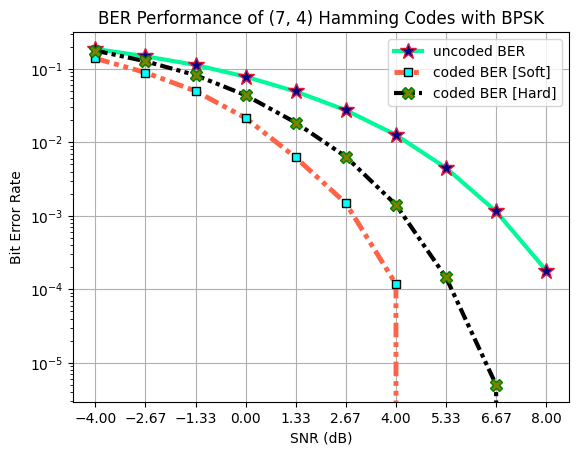

In [5]:
fig, ax = plt.subplots()

ax.semilogy(SNRdB, uncodedBER,   'mediumspringgreen', lw = 3, linestyle = "solid", 
            marker = "*", ms = 12, mec = "crimson", mfc = "darkblue", label = "uncoded BER")
ax.semilogy(SNRdB, codedBERsoft, 'tomato', lw = 3.5, linestyle = (0, (3, 1, 1, 1, 1, 1)), 
            marker = "s", ms = 6, mec = "k", mfc = "cyan", label = "coded BER [Soft]")
ax.semilogy(SNRdB, codedBERhard, 'k', lw = 3, linestyle = (0, (3, 1, 1, 1, 1, 1)), 
            marker = "X", ms = 9, mec = "green", mfc = "olive", label = "coded BER [Hard]")
ax.legend()
ax.set_xticks(SNRdB)
ax.grid()
ax.set_ylabel("Bit Error Rate")
ax.set_xlabel("SNR (dB)")
ax.set_title("BER Performance of ("+str(n)+", "+str(k)+") Hamming Codes with BPSK")
plt.show()

## Performance Evaluation: SNR vs BLER
Following plots demonstate the BLER vs SNR performance of following:

 - Hamming decoder (Syndrome based decoder) taking hard bits (0/1) as inputs.
 - Hamming decoder (Sphere decoder) taking soft bits (log likelihood ratios) as inputs.

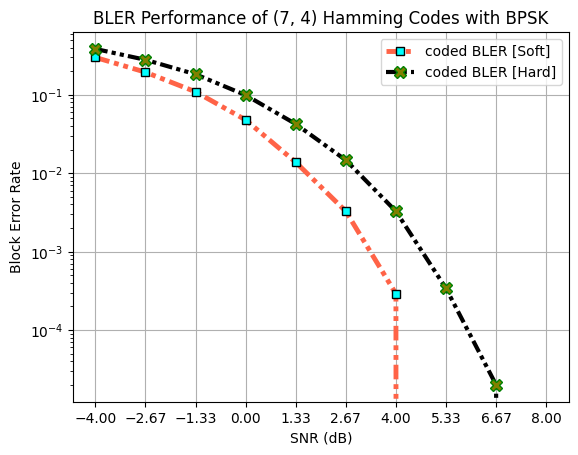

In [6]:
fig, ax = plt.subplots()

ax.semilogy(SNRdB, codedBLERsoft, 'tomato', lw = 3.5, linestyle = (0, (3, 1, 1, 1, 1, 1)), 
            marker = "s", ms = 6, mec = "k", mfc = "cyan", label = "coded BLER [Soft]")
ax.semilogy(SNRdB, codedBLERhard, 'k', lw = 3, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "X", 
            ms = 9, mec = "green", mfc = "olive", label = "coded BLER [Hard]")
ax.legend()
ax.set_xticks(SNRdB)
ax.grid()
ax.set_ylabel("Block Error Rate")
ax.set_xlabel("SNR (dB)")
ax.set_title("BLER Performance of ("+str(n)+", "+str(k)+") Hamming Codes with BPSK")
plt.show()

## Conclusions

 - The Hamming decoder with soft inputs outputs the rest of the techniques for both BER as well as BLER.
 - Sphere Decoding has very high complexity which scales exponentially with parity bits (``m``).